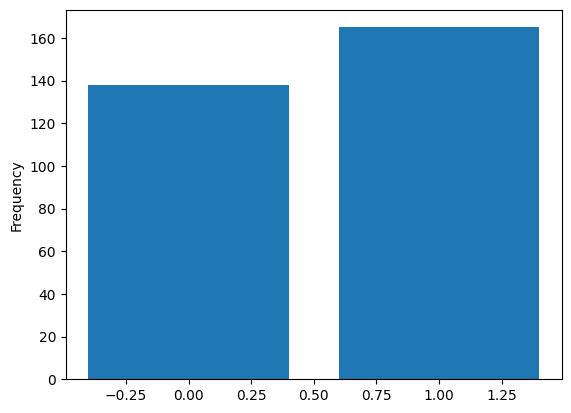

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [1]:
import pandas as pd

heart = pd.read_csv("data/raw_dataset/heart.csv")

from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt

# separate the target variable from the features
heart_target = heart['output']
heart_data = heart.drop('output', axis=1)

# plot the class distribution
class_dist = pd.Series(heart_target).value_counts()
plt.bar(class_dist.index, class_dist)
plt.ylabel("Frequency")
plt.show()

heart_data.head()


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# list all numerical features that we want to re-scale
numeric_features = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
numeric_transformer = Pipeline([ ('scaler', StandardScaler()) ])

# list all categorical features that we want to encode using OneHotEncoder
categorical_features = ['cp', 'restecg', 'caa', 'thall', 'slp']
categorical_transformer = Pipeline([ ('onehot', OneHotEncoder()) ])

# list all ordinal features that we want to encode using OrdinalEncoder
ordinal_features = ['sex',  'fbs', 'exng']
ordinal_transformer = Pipeline([ ('ordinal', OrdinalEncoder()) ])

# define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)])

print("Scaled data:")
display(preprocessor.fit_transform(heart_data))

pipeline = Pipeline([ 
    ('preprocessing', preprocessor), 
    # ('balancing', RandomOverSampler()),
    ('estimator', DecisionTreeClassifier()) ])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


Scaled data:


array([[ 0.9521966 ,  0.76395577, -0.25633371, ...,  1.        ,
         1.        ,  0.        ],
       [-1.91531289, -0.09273778,  0.07219949, ...,  1.        ,
         0.        ,  0.        ],
       [-1.47415758, -0.09273778, -0.81677269, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.50364073,  0.70684287, -1.029353  , ...,  1.        ,
         1.        ,  0.        ],
       [ 0.29046364, -0.09273778, -2.2275329 , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.29046364, -0.09273778, -0.19835726, ...,  0.        ,
         0.        ,  0.        ]])

First prediction without parameter optimization:

In [9]:
prediction = cross_val_predict(pipeline, heart_data, heart_target, cv=cv)

def cost_function(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred)
    return cm[0][1] * 100 + cm[1][0] * 1

cm = confusion_matrix(heart_target, prediction)
cost = cost_function(heart_target, prediction)
acc = accuracy_score(heart_target, prediction)

print("Decision Tree with accuracy of {} and cost {}".format(acc, cost))
print(cm)
print(classification_report(heart_target, prediction))

Decision Tree with accuracy of 0.7326732673267327 and cost 4338
[[ 95  43]
 [ 38 127]]
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       138
           1       0.75      0.77      0.76       165

    accuracy                           0.73       303
   macro avg       0.73      0.73      0.73       303
weighted avg       0.73      0.73      0.73       303



Default Parameters for decision tree:

In [11]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Now, find the best params:

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# define the parameter grid
parameters = {
    'estimator__criterion':['gini', 'entropy'], 
    'estimator__max_depth':[ 2, 3, 4, 5, 6, 7, 8, None],
    'estimator__min_samples_split' :[2,3,4,5,6,7,8,9,10]
}

# define the folds for the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create a scorer for the grid search
cost_score = make_scorer(cost_function, greater_is_better=False)

# create the grid search estimator
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=cost_score, cv=stratified_10_fold_cv)

# cross-validate
prediction = cross_val_predict(grid_search_estimator, heart_data, heart_target, cv=cv, n_jobs=-1)

# calculate costs
cm = confusion_matrix(heart_target, prediction)
cost = cost_function(heart_target, prediction)
acc = accuracy_score(heart_target, prediction)

print("Optimised Decision Tree with accuracy of {} and cost {}".format(acc, cost))
print(cm)
print(classification_report(heart_target, prediction))
print(cm[1][0])

# fit the grid search (= determine the optimal parameters)
grid_search_estimator.fit(heart_data, heart_target)
print("Optimised Parameters: {}".format(grid_search_estimator.best_params_))

Optimised Decision Tree with accuracy of 0.7623762376237624 and cost 4824
[[ 90  48]
 [ 24 141]]
              precision    recall  f1-score   support

           0       0.79      0.65      0.71       138
           1       0.75      0.85      0.80       165

    accuracy                           0.76       303
   macro avg       0.77      0.75      0.76       303
weighted avg       0.77      0.76      0.76       303

24
Optimised Parameters: {'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__min_samples_split': 3}


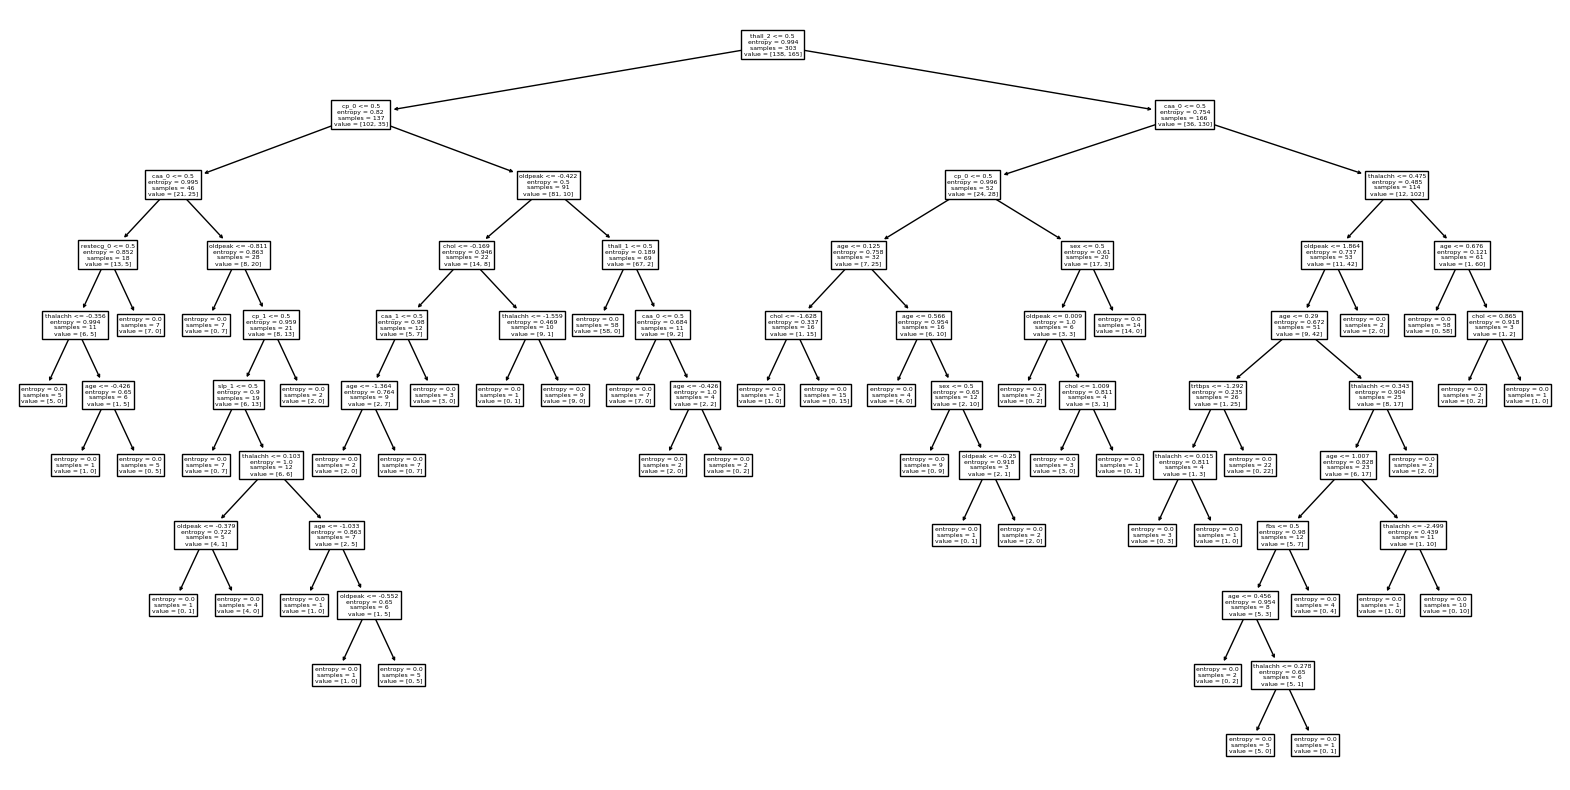

In [15]:
from sklearn import tree

estimator = grid_search_estimator.best_estimator_.named_steps['estimator']
pre = grid_search_estimator.best_estimator_.named_steps['preprocessing']
feature_names = numeric_features + list(pre.named_transformers_['cat'].get_feature_names_out(categorical_features)) + ordinal_features

plt.figure(figsize=(20,10))
tree.plot_tree(estimator,
               feature_names=feature_names)
plt.show()